**Anna Smith**

**GitHub username: acs-233**

**Imperial College London - MSc EDSML - IRP**
# **Land Use Regression Modelling for $\textnormal{BECO}_2\textnormal{N}$ data**

In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import spearmanr, pearsonr
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
import re
from statsmodels.api import OLS, add_constant
from pathlib import Path

In [43]:
from bayareaco2.models.data import fit_scaler, scale_features
from bayareaco2.models.data import drop_high_vif
from bayareaco2.models.data import plot_corr
from bayareaco2.models.ols import OLS_Model

## Reading in Data

In [6]:
path = Path.cwd().parent.parent.parent / 'Data' / 'CO2' / 'daily_avg_BEACO2N.csv'
co2 = pd.read_csv(path)

path = Path.cwd().parent.parent.parent / 'Data' / 'features.csv'
features = pd.read_csv(path)

# Merging data
df = co2.merge(features, on='node_id')

In [7]:
# Confirming no missing values
np.max(df.isna().sum())

0

In [8]:
df

,node_id,date,timestamp,co2,temp,pressure,rh,year,month,lat,...,avg_pop_dens_50m,avg_pop_dens_100m,avg_pop_dens_200m,avg_pop_dens_300m,avg_pop_dens_500m,avg_pop_dens_1000m,avg_pop_dens_2000m,avg_pop_dens_3000m,avg_pop_dens_4000m,avg_pop_dens_5000m
0,2,2015-02-03,2015-02-03 11:30:00.000000000,436.042374,16.980245,1015.074005,63.821168,2015,2,38.289,...,169.400000,169.400000,169.400000,169.400000,169.400000,169.400000,512.977544,720.457390,765.629357,724.831441
1,2,2015-02-04,2015-02-04 11:30:00.000000000,438.478472,15.822596,1013.333705,68.045385,2015,2,38.289,...,169.400000,169.400000,169.400000,169.400000,169.400000,169.400000,512.977544,720.457390,765.629357,724.831441
2,2,2015-03-14,2015-03-14 11:30:00.000000000,450.383408,22.581634,1013.953940,54.688219,2015,3,38.289,...,169.400000,169.400000,169.400000,169.400000,169.400000,169.400000,512.977544,720.457390,765.629357,724.831441
3,2,2015-03-15,2015-03-15 11:30:00.000000000,425.889624,19.821010,1013.194940,49.344820,2015,3,38.289,...,169.400000,169.400000,169.400000,169.400000,169.400000,169.400000,512.977544,720.457390,765.629357,724.831441
4,2,2015-03-16,2015-03-16 11:30:00.000000000,439.721886,18.596646,1013.002304,62.354269,2015,3,38.289,...,169.400000,169.400000,169.400000,169.400000,169.400000,169.400000,512.977544,720.457390,765.629357,724.831441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43897,286,2024-03-22,2024-03-22 11:30:00.000000000,434.502675,20.390149,1014.145432,49.324725,2024,3,37.847,...,15127.053329,15953.607262,16300.528823,16150.012015,16387.774742,14981.046811,12583.537953,12283.743192,10896.300370,9445.255071
43898,286,2024-03-23,2024-03-23 11:30:00.000000000,425.356008,18.448980,1009.636745,51.039510,2024,3,37.847,...,15127.053329,15953.607262,16300.528823,16150.012015,16387.774742,14981.046811,12583.537953,12283.743192,10896.300370,9445.255071
43899,286,2024-03-24,2024-03-24 11:30:00.000000000,421.349008,20.199887,1010.013281,42.642338,2024,3,37.847,...,15127.053329,15953.607262,16300.528823,16150.012015,16387.774742,14981.046811,12583.537953,12283.743192,10896.300370,9445.255071
43900,286,2024-03-25,2024-03-25 11:30:00.000000000,423.765209,20.338516,1014.235041,42.538865,2024,3,37.847,...,15127.053329,15953.607262,16300.528823,16150.012015,16387.774742,14981.046811,12583.537953,12283.743192,10896.300370,9445.255071


In [9]:
# Defining dependent variable
y = df['co2'].copy()

In [10]:
# Combining feature labels
feature_vars = features.drop(columns='node_id').columns.to_list()
feature_vars.append('temp')
feature_vars.append('pressure')
feature_vars.append('rh')

In [11]:
node_id = df['node_id'].copy()

In [12]:
# Defining dependent variables
X = df[feature_vars].copy()

In [13]:
# Inspecting X -- 123 features
X

,Built_Area_area_50m,Rangeland_area_50m,Trees_area_50m,Water_area_50m,Bare_Ground_area_50m,Crops_area_50m,Flooded_Vegetation_area_50m,Built_Area_area_100m,Rangeland_area_100m,Trees_area_100m,...,avg_pop_dens_300m,avg_pop_dens_500m,avg_pop_dens_1000m,avg_pop_dens_2000m,avg_pop_dens_3000m,avg_pop_dens_4000m,avg_pop_dens_5000m,temp,pressure,rh
0,7841.371226,0.0,0.0,0.0,0,0,0,31365.484905,0.0,0.0,...,169.400000,169.400000,169.400000,512.977544,720.457390,765.629357,724.831441,16.980245,1015.074005,63.821168
1,7841.371226,0.0,0.0,0.0,0,0,0,31365.484905,0.0,0.0,...,169.400000,169.400000,169.400000,512.977544,720.457390,765.629357,724.831441,15.822596,1013.333705,68.045385
2,7841.371226,0.0,0.0,0.0,0,0,0,31365.484905,0.0,0.0,...,169.400000,169.400000,169.400000,512.977544,720.457390,765.629357,724.831441,22.581634,1013.953940,54.688219
3,7841.371226,0.0,0.0,0.0,0,0,0,31365.484905,0.0,0.0,...,169.400000,169.400000,169.400000,512.977544,720.457390,765.629357,724.831441,19.821010,1013.194940,49.344820
4,7841.371226,0.0,0.0,0.0,0,0,0,31365.484905,0.0,0.0,...,169.400000,169.400000,169.400000,512.977544,720.457390,765.629357,724.831441,18.596646,1013.002304,62.354269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43897,7841.371226,0.0,0.0,0.0,0,0,0,31365.484906,0.0,0.0,...,16150.012015,16387.774742,14981.046811,12583.537953,12283.743192,10896.300370,9445.255071,20.390149,1014.145432,49.324725
43898,7841.371226,0.0,0.0,0.0,0,0,0,31365.484906,0.0,0.0,...,16150.012015,16387.774742,14981.046811,12583.537953,12283.743192,10896.300370,9445.255071,18.448980,1009.636745,51.039510
43899,7841.371226,0.0,0.0,0.0,0,0,0,31365.484906,0.0,0.0,...,16150.012015,16387.774742,14981.046811,12583.537953,12283.743192,10896.300370,9445.255071,20.199887,1010.013281,42.642338
43900,7841.371226,0.0,0.0,0.0,0,0,0,31365.484906,0.0,0.0,...,16150.012015,16387.774742,14981.046811,12583.537953,12283.743192,10896.300370,9445.255071,20.338516,1014.235041,42.538865


In [14]:
# Inspecting y
y

0        436.042374
1        438.478472
2        450.383408
3        425.889624
4        439.721886
            ...    
43897    434.502675
43898    425.356008
43899    421.349008
43900    423.765209
43901    426.198336
Name: co2, Length: 43902, dtype: float64

In [15]:
node_id

0          2
1          2
2          2
3          2
4          2
        ... 
43897    286
43898    286
43899    286
43900    286
43901    286
Name: node_id, Length: 43902, dtype: int64

# Data preparation

In [16]:
buffer_groups = {
    'Built_Area': [col for col in X.columns if 'Built_Area' in col],
    'Rangeland': [col for col in X.columns if 'Rangeland' in col],
    'Trees': [col for col in X.columns if 'Trees' in col],
    'Water': [col for col in X.columns if 'Water' in col],
    'Bare_Ground': [col for col in X.columns if 'Bare_Ground' in col],
    'Crops': [col for col in X.columns if 'Crops' in col],
    'Flooded_Vegetation': [col for col in X.columns if 'Flooded_Vegetation' in col],
    'Industrial_area': [col for col in X.columns if 'Industrial_area' in col],
    'total_AADT': [col for col in X.columns if 'total_AADT' in col],
    'total_road_length': [col for col in X.columns if 'total_road_length' in col],
    'avg_ndvi': [col for col in X.columns if 'avg_ndvi' in col],
    'avg_pop_dens': [col for col in X.columns if 'avg_pop_dens' in col],
    'temp': ['temp'],
    'pressure': ['pressure'],
    'rh': ['rh']
}

## a-priori hypotheses

In [17]:
# a-priori hypotheses
a_priori = {
    'Built_Area': 1,  # More buildings can mean more human activity and emissions
    'Rangeland': -1,   # Less human activity, more green space which can absorb CO2
    'Trees': -1,       # Trees absorb CO2
    'Water': -1,       # Bodies of water can absorb CO2 and have less human activity
    'Bare_Ground': -1, # Less human activity, similar to rangeland
    'Crops': -1,       # Plants can absorb CO2
    'Flooded_Vegetation': -1, # Vegetation (and water) in general absorbs CO2
    'Industrial_area': 1, # Industries are sources of CO2 emissions
    'total_AADT': 1,   # Higher traffic volume leads to more emissions
    'total_road_length': 1, # More roads can imply more vehicles and emissions
    'avg_ndvi': -1,     # Higher NDVI indicates more vegetation, which absorbs CO2
    'avg_pop_dens': 1, # Higher population density generally leads to higher emissions
    'temp': -1,         # High temperature ~ low pressure, greater dispersion of molecules
    'pressure': 1,     # High pressure ~ high density, greater buildup of molecules
    'rh': 1            # https://iopscience.iop.org/article/10.1088/1757-899X/884/1/012007
}

# Feature Selection

In [18]:
# Checking for zero columns
zero_columns = [col for col in X.columns if (X[col] == 0).all()]
print(f"{len(zero_columns)} columns with all zeros:")
zero_columns

17 columns with all zeros:


['Bare_Ground_area_50m',
 'Crops_area_50m',
 'Flooded_Vegetation_area_50m',
 'Bare_Ground_area_100m',
 'Crops_area_100m',
 'Flooded_Vegetation_area_100m',
 'Bare_Ground_area_200m',
 'Crops_area_200m',
 'Flooded_Vegetation_area_200m',
 'Bare_Ground_area_300m',
 'Crops_area_300m',
 'Flooded_Vegetation_area_300m',
 'Bare_Ground_area_500m',
 'total_AADT_50m',
 'total_AADT_100m',
 'total_AADT_200m',
 'total_road_length_50m']

In [19]:
# Dropping zero columns
X = X.drop(columns = zero_columns)

In [20]:
# Standardizing the data
scaler = fit_scaler(X)
X_scaled = scale_features(scaler, X)

In [21]:
# Splitting data
X_train_full, X_test_full, y_train_full, y_test_full, node_id_train_full, node_id_test_full = train_test_split(X_scaled, y, node_id, test_size=0.2, random_state=42)

In [22]:
# Number of features
print(f"Number of features: {len(X_train_full.columns)}")

Number of features: 106


## Pearson's correlation coefficient (linear)

In [23]:
pearson_results = []
for column in X_train_full.columns:
    if np.std(X_train_full[column]) == 0:
        print(f"Column {column} is constant.")
        coef = np.nan
    else:
        coef, _ = pearsonr(X_train_full[column], y_train_full)
    pearson_results.append((column, coef))

# Sort by absolute value of coefficients in descending order
pearson_results_sorted = sorted(pearson_results, key=lambda x: abs(x[1]) if not np.isnan(x[1]) else 0, reverse=True)

# Print all zipped combinations
for feature, coef in pearson_results_sorted:
    print(f"{feature}: {coef:.2f}")

temp: -0.36
pressure: 0.33
Trees_area_3000m: -0.15
Built_Area_area_500m: 0.15
Built_Area_area_1000m: 0.15
Built_Area_area_2000m: 0.15
Trees_area_4000m: -0.14
Built_Area_area_3000m: 0.14
Trees_area_5000m: -0.13
Built_Area_area_300m: 0.13
Trees_area_2000m: -0.13
Built_Area_area_100m: 0.13
Built_Area_area_200m: 0.13
Built_Area_area_50m: 0.12
Built_Area_area_4000m: 0.11
Water_area_500m: -0.11
Water_area_300m: -0.11
total_road_length_2000m: 0.11
total_road_length_1000m: 0.11
Water_area_50m: -0.11
Water_area_100m: -0.11
Water_area_200m: -0.11
total_road_length_3000m: 0.10
Water_area_1000m: -0.09
Trees_area_1000m: -0.09
total_AADT_3000m: 0.09
Trees_area_500m: -0.08
Built_Area_area_5000m: 0.08
Trees_area_100m: -0.08
Trees_area_50m: -0.08
total_road_length_4000m: 0.08
Crops_area_500m: -0.08
Crops_area_1000m: -0.08
total_AADT_2000m: 0.08
Crops_area_2000m: -0.08
Industrial_area_50m: -0.08
avg_pop_dens_1000m: 0.08
Crops_area_3000m: -0.08
Trees_area_200m: -0.08
Trees_area_300m: -0.08
Industrial_are

## $R^{2}$

In [24]:
f_values, p_values = f_regression(X_train_full, y_train_full)
r2_values = f_values / (f_values + (len(y_train_full) - 1))
r2_results = list(zip(X_train_full.columns, r2_values))
r2_results_sorted = sorted(r2_results, key=lambda x: x[1], reverse=True)

for feature, r2 in r2_results_sorted:
    print(f"{feature}: {r2:.2f}")

temp: 0.13
pressure: 0.11
Trees_area_3000m: 0.02
Built_Area_area_500m: 0.02
Built_Area_area_1000m: 0.02
Built_Area_area_2000m: 0.02
Trees_area_4000m: 0.02
Built_Area_area_3000m: 0.02
Trees_area_5000m: 0.02
Built_Area_area_300m: 0.02
Trees_area_2000m: 0.02
Built_Area_area_100m: 0.02
Built_Area_area_200m: 0.02
Built_Area_area_50m: 0.01
Built_Area_area_4000m: 0.01
Water_area_500m: 0.01
Water_area_300m: 0.01
total_road_length_2000m: 0.01
total_road_length_1000m: 0.01
Water_area_50m: 0.01
Water_area_100m: 0.01
Water_area_200m: 0.01
total_road_length_3000m: 0.01
Water_area_1000m: 0.01
Trees_area_1000m: 0.01
total_AADT_3000m: 0.01
Trees_area_500m: 0.01
Built_Area_area_5000m: 0.01
Trees_area_100m: 0.01
Trees_area_50m: 0.01
total_road_length_4000m: 0.01
Crops_area_500m: 0.01
Crops_area_1000m: 0.01
total_AADT_2000m: 0.01
Crops_area_2000m: 0.01
Industrial_area_50m: 0.01
avg_pop_dens_1000m: 0.01
Crops_area_3000m: 0.01
Trees_area_200m: 0.01
Trees_area_300m: 0.01
Industrial_area_5000m: 0.01
total_AA

## Spearman's rank coefficient (non-linear)

In [25]:
spearman_results = []
for column in X_train_full.columns:
    if np.std(X_train_full[column]) == 0:
        print(f"Column {column} is constant.")
        coef = np.nan
    else:
        coef, _ = spearmanr(X_train_full[column], y_train_full)
    spearman_results.append((column, coef))

# Sort by absolute value of coefficients in descending order
spearman_results_sorted = sorted(spearman_results, key=lambda x: abs(x[1]) if not np.isnan(x[1]) else 0, reverse=True)

# Print all zipped combinations
for feature, coef in spearman_results_sorted:
    print(f"{feature}: {coef:.2f}")

temp: -0.42
pressure: 0.37
Flooded_Vegetation_area_5000m: 0.14
Flooded_Vegetation_area_4000m: 0.12
Built_Area_area_2000m: 0.11
Built_Area_area_1000m: 0.11
Built_Area_area_3000m: 0.10
Trees_area_1000m: -0.10
rh: -0.10
Water_area_100m: -0.10
Water_area_50m: -0.10
Trees_area_500m: -0.10
Built_Area_area_500m: 0.10
Crops_area_5000m: 0.09
Built_Area_area_50m: 0.09
avg_pop_dens_500m: 0.09
Trees_area_50m: -0.09
Industrial_area_4000m: 0.09
avg_pop_dens_200m: 0.09
Built_Area_area_4000m: 0.09
Industrial_area_3000m: 0.09
avg_pop_dens_300m: 0.09
total_road_length_1000m: 0.09
avg_pop_dens_100m: 0.08
avg_pop_dens_50m: 0.08
Industrial_area_5000m: 0.08
Flooded_Vegetation_area_3000m: 0.08
total_road_length_2000m: 0.08
Crops_area_1000m: -0.08
total_AADT_3000m: 0.08
Trees_area_2000m: -0.07
total_road_length_3000m: 0.07
Crops_area_4000m: 0.07
Built_Area_area_300m: 0.07
Water_area_300m: -0.07
Water_area_200m: -0.07
total_AADT_2000m: 0.07
Industrial_area_2000m: 0.07
Bare_Ground_area_5000m: 0.06
Water_area_50

## SelectKBest

In [26]:
# Define feature selection
fs = SelectKBest(score_func=f_regression, k=25)

# Apply feature selection
X_selected = fs.fit_transform(X_train_full, y_train_full)

# Get the scores and mask of selected features
scores = fs.scores_
mask = fs.get_support()

# Get the selected features and their scores
selected_features = np.array(X_train_full.columns)[mask]
selected_scores = scores[mask]

# Sort the selected features by their scores in descending order
sorted_indices = np.argsort(selected_scores)[::-1]
sorted_features = selected_features[sorted_indices]
sorted_scores = selected_scores[sorted_indices]

# Print the selected features in order of importance
for feature, score in zip(sorted_features, sorted_scores):
    print(f"{feature}: {score:.2f}")

temp: 5376.24
pressure: 4204.61
Trees_area_3000m: 773.66
Built_Area_area_500m: 765.11
Built_Area_area_1000m: 760.80
Built_Area_area_2000m: 754.75
Trees_area_4000m: 739.76
Built_Area_area_3000m: 662.08
Trees_area_5000m: 640.95
Built_Area_area_300m: 639.80
Trees_area_2000m: 594.07
Built_Area_area_100m: 584.64
Built_Area_area_200m: 576.23
Built_Area_area_50m: 497.86
Built_Area_area_4000m: 470.51
Water_area_500m: 454.86
Water_area_300m: 423.60
total_road_length_2000m: 412.08
total_road_length_1000m: 410.54
Water_area_50m: 402.00
Water_area_100m: 398.51
Water_area_200m: 395.32
total_road_length_3000m: 321.17
Water_area_1000m: 305.17
Trees_area_1000m: 287.47


# ExtraTreeRegressor

In [27]:
# Initialize the model
model = ExtraTreesRegressor()

# Fit the model
model.fit(X_train_full, y_train_full)

# Get feature importances
importances = model.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Arrange the feature names in the same order as the importances
features = X_train_full.columns[indices]

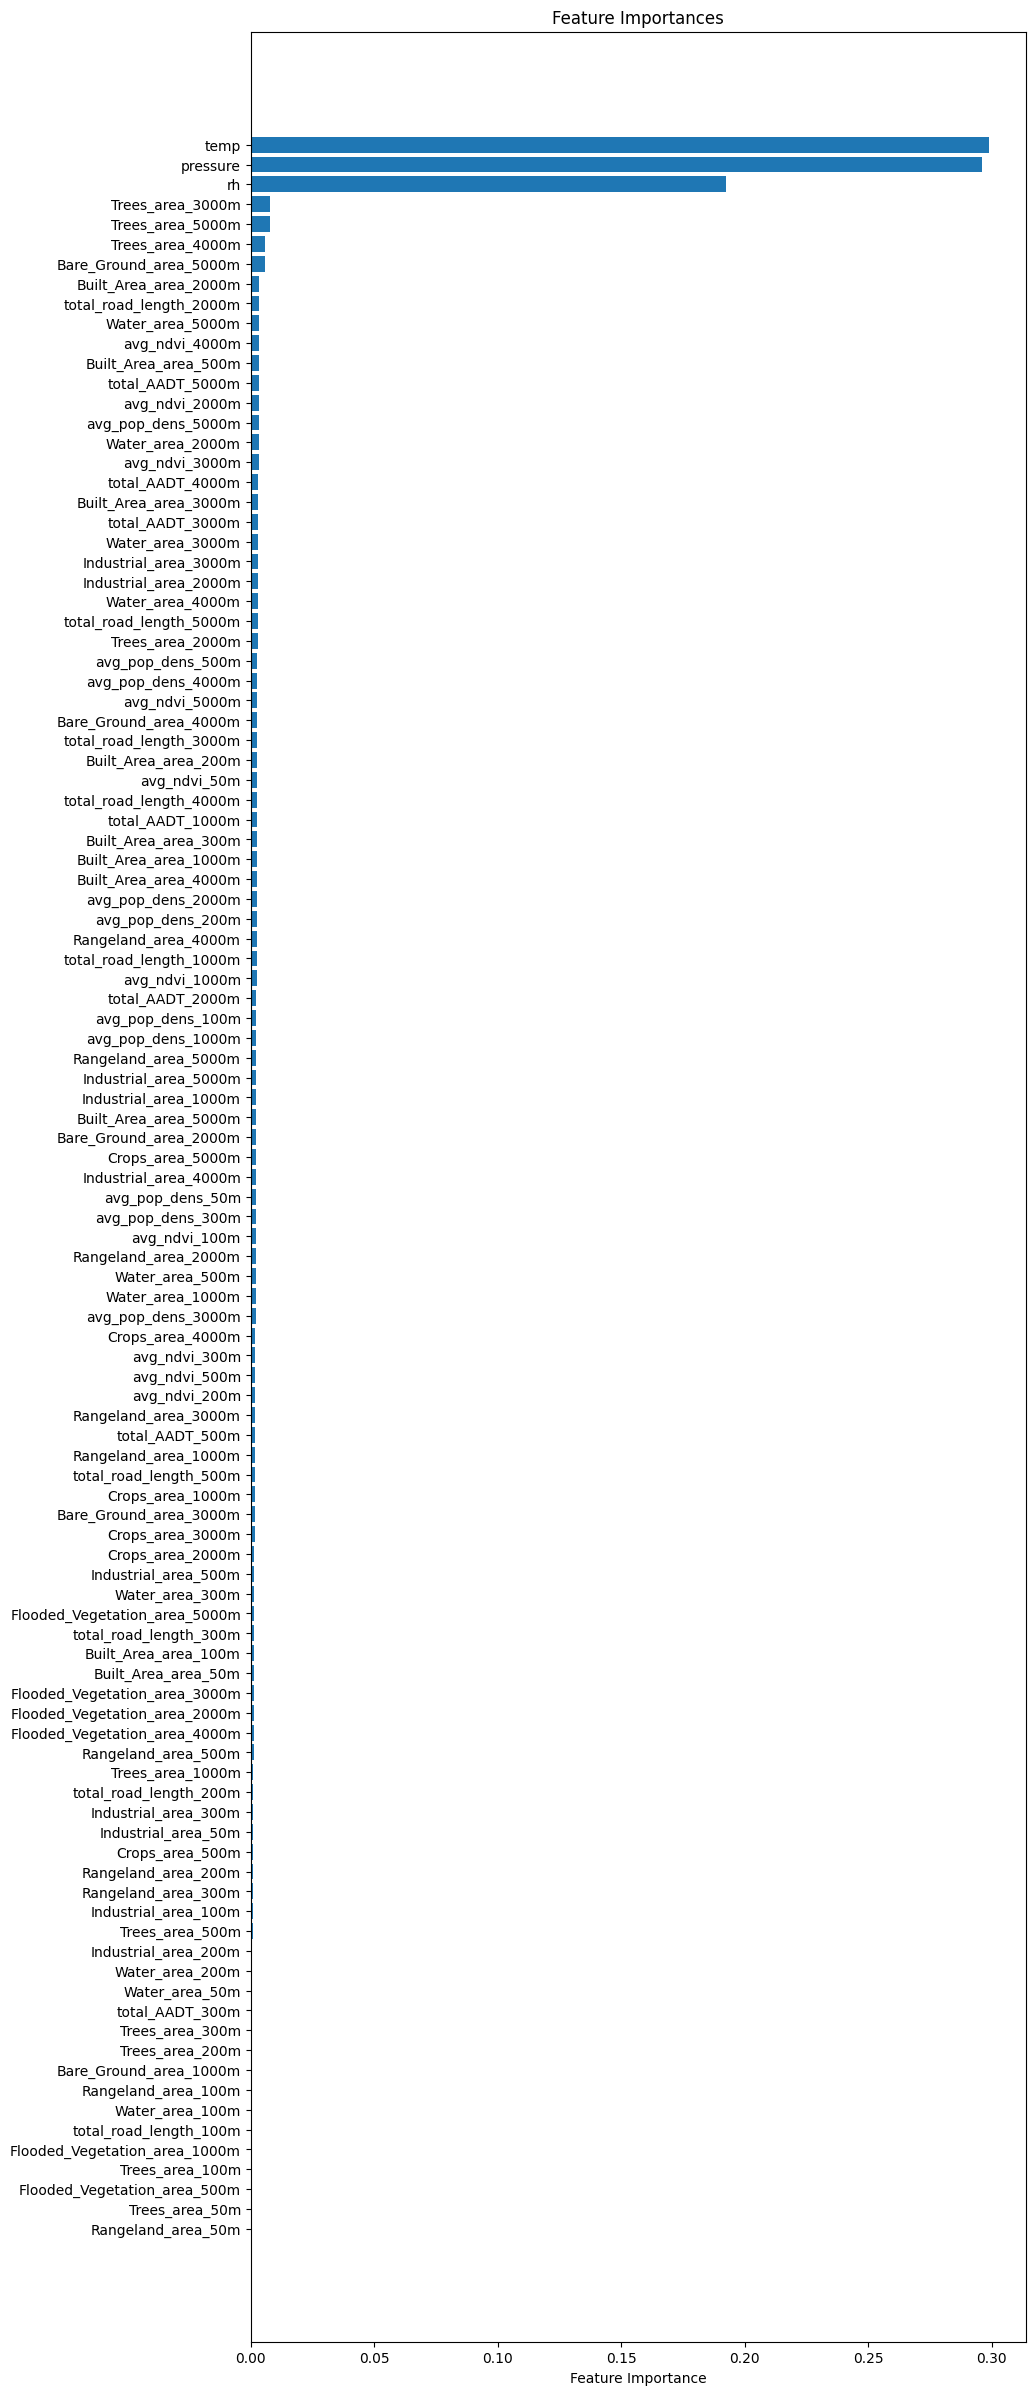

In [28]:
# Create a horizontal bar plot
plt.figure(figsize=(10, 30))  # Adjust the height for better readability
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X_train_full.columns[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features at the top
plt.show()

# Comparing Literature Approaches

In [29]:
X_train, X_val, y_train, y_val, node_id_train, node_id_val= train_test_split(X_train_full, y_train_full, node_id_train_full, test_size=0.2, random_state=42)

## Baseline Model (all features)

R²: 0.32
Adjusted R²: 0.32
Mean Squared Error (MSE): 297.68
Root Mean Squared Error (RMSE): 17.25
Mean Absolute Error (MAE): 13.08


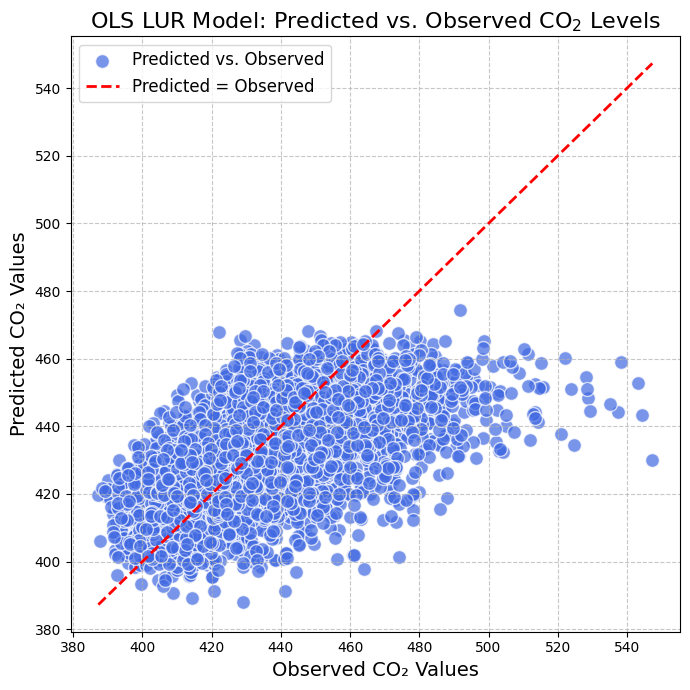

In [35]:
baseline_model = OLS_Model()
baseline_model.fit(X_train, y_train);
baseline_lur_results = baseline_model.evaluate(X_val, y_val)

In [36]:
cv_train_lur_results = baseline_model.cross_validate(X_train, y_train)

Cross-Validation Mean Metrics:
R²: 0.32
Adjusted R²: 0.30
Mean Squared Error (MSE): 303.45
Root Mean Squared Error (RMSE): 17.42
Mean Absolute Error (MAE): 13.14


## Larkin et al.

**Feature Selection**
* LASSO regularization for feature selection (glmnet in R)
    - Suitable for highly intercorrelated predictors (e.g. same variable, different buffer radii)
    - Enhances interpretability by eliminating non-significant variables
* LASSO parameters:
    - Standardizing independent variables
    - Minimizing MSE
    - Forcing direction of variable coefficients to confirm a-priori hypothesis
* LASSO model with a lambda cross-validation score of one standard deviation from the minimum cross-validation score selected as model of choice
* Weighted observations by seasonal and geographical coverage
* Multiple buffers of same land use classification only allowed in final model if larger radius was at least 5x greater than the smaller radius
    - In attempt to reduct multicollinearity
* Predictor variables included in model if they:
    - ... significantly reduced MSE of model predictions ($p < 0.05$)
    - ... increased $R^2$ by at least 1 percent
    - ... demonstrated a VIF less than 5

**Model Evaluation**
* Leave 10% out cross-validation, in which 10% of sensors were randomly sampled as testing data
* Cross-validation repeated in bootstrap fashion, 10,000 times, to evaluate performance metrics
* Performance metrics:
    - Root mean squared error (RMSE)
    - Mean absolute error (MAE)
    - Adjusted $R^2$ (Adj $R^2$)
    - Mean percent bias (MB)
    - Mean absolute bias (MAB)

In [37]:
# Splitting the data
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

def calculate_adj_r2(n, p, r2):
    """Calculate the adjusted R-squared value."""
    return 1 - (1 - r2) * ((n - 1) / (n - p - 1))

# Get the alpha (lambda) value with one standard error and fitting LASSO model
lasso_cv = LassoCV(cv=10, random_state=42, max_iter=10000).fit(X_train, y_train)
alpha_1se = lasso_cv.alphas_[np.argmin(lasso_cv.mse_path_.mean(axis=1) + lasso_cv.mse_path_.std(axis=1))]
lasso = Lasso(alpha=alpha_1se, random_state=42, max_iter=10000)
lasso.fit(X_train, y_train)

# Confirming a-priori hypotheses
lasso_coef = lasso.coef_
non_zero_coefs = X_train.columns[(lasso_coef != 0)]
    
a_priori_features = []
    
for feature in non_zero_coefs:
    # Find the group that the feature belongs to
    group = next((grp for grp, features in buffer_groups.items() if feature in features), None)
    
    # Getting and confirming group hypothesis direction
    if group:
        hypothesis_direction = a_priori.get(group, None)
        coef_direction = np.sign(lasso_coef[X_train.columns.get_loc(feature)])
            
        if hypothesis_direction is None or hypothesis_direction == coef_direction:
            a_priori_features.append(feature)

# Enforcing buffer radius constraint
radii_selected = []

for group, buffers in buffer_groups.items():
    selected_buffers = [buf for buf in buffers if buf in a_priori_features]
    if len(selected_buffers) > 1:
            sorted_buffers = sorted(selected_buffers, key=lambda x: int(re.findall(r'\d+', x)[0]))
            radii_selected.append(sorted_buffers[0])
            for i in range(1, len(sorted_buffers)):
                if int(re.findall(r'\d+', sorted_buffers[i])[0]) >= 5 * int(re.findall(r'\d+', sorted_buffers[0])[0]):
                    radii_selected.append(sorted_buffers[i])
    else:
        radii_selected.extend(selected_buffers)

X_train_radii = X_train[radii_selected]

# Dropping high VIF features
X_train_radii, vif = drop_high_vif(X_train_radii, threshold=5)

pval_threshold = 0.05
r2_threshold = 0.01

current_adj_r2 = 0
larkin_features = []

for feature in X_train.columns:
    X_temp = X_train[larkin_features + [feature]]
    model = sm.OLS(y_train, sm.add_constant(X_temp)).fit()
    y_pred = model.predict(sm.add_constant(X_temp))
    
    p_value = model.pvalues[feature]
    r2 = model.rsquared
    n = len(y_train)
    p = 1 
    adj_r2 = calculate_adj_r2(n, p, r2)

    if (adj_r2 - current_adj_r2 > r2_threshold) and (p_value < pval_threshold):
        larkin_features.append(feature)
        current_adj_r2 = adj_r2

In [38]:
larkin_X_train = X_train[larkin_features]
larkin_X_test = X_val[larkin_features]

R²: 0.27
Adjusted R²: 0.27
Mean Squared Error (MSE): 321.81
Root Mean Squared Error (RMSE): 17.94
Mean Absolute Error (MAE): 13.61


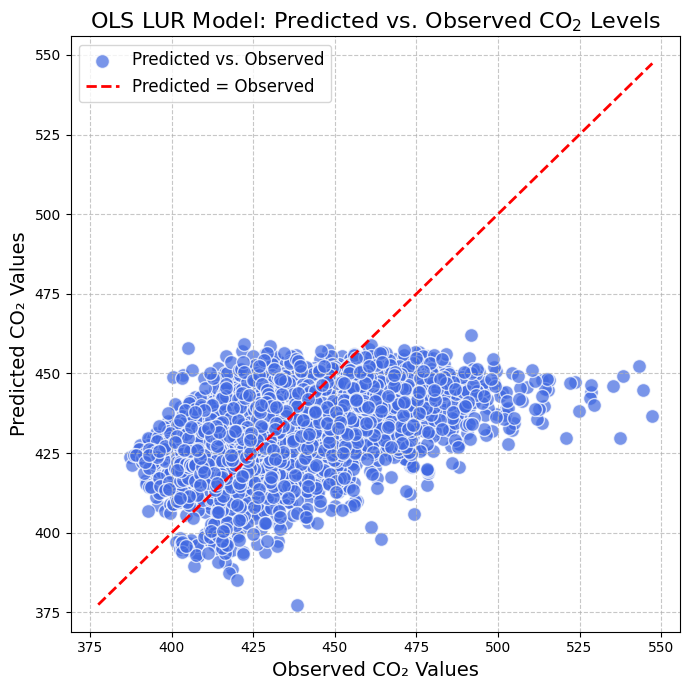

In [40]:
larkin_model = OLS_Model()
larkin_model.fit(larkin_X_train, y_train);
larkin_lur_results = larkin_model.evaluate(larkin_X_test, y_val)

In [49]:
cv_larkin_lur_results = larkin_model.cross_validate(larkin_X_train, y_train)

Cross-Validation Mean Metrics:
R²: 0.26
Adjusted R²: 0.26
Mean Squared Error (MSE): 327.28
Root Mean Squared Error (RMSE): 18.09
Mean Absolute Error (MAE): 13.72


In [42]:
larkin_model.feature_stats(larkin_X_train, y_train)

,Feature,Coefficient,Standard Error,p-Value,VIF,Partial R²
0,Built_Area_area_50m,1.860701,0.136013,1.822635e-42,1.593004,0.006619
1,Built_Area_area_1000m,0.475554,0.146285,1.151838e-03,1.860537,0.000376
2,Trees_area_3000m,3.599645,0.192350,1.130792e-77,3.227068,0.012314
3,temp,-7.930909,0.122538,0.000000e+00,1.294635,0.129777
4,pressure,8.401572,0.189459,0.000000e+00,3.124945,0.065429
5,rh,-3.773208,0.120389,5.643995e-212,1.238598,0.033790


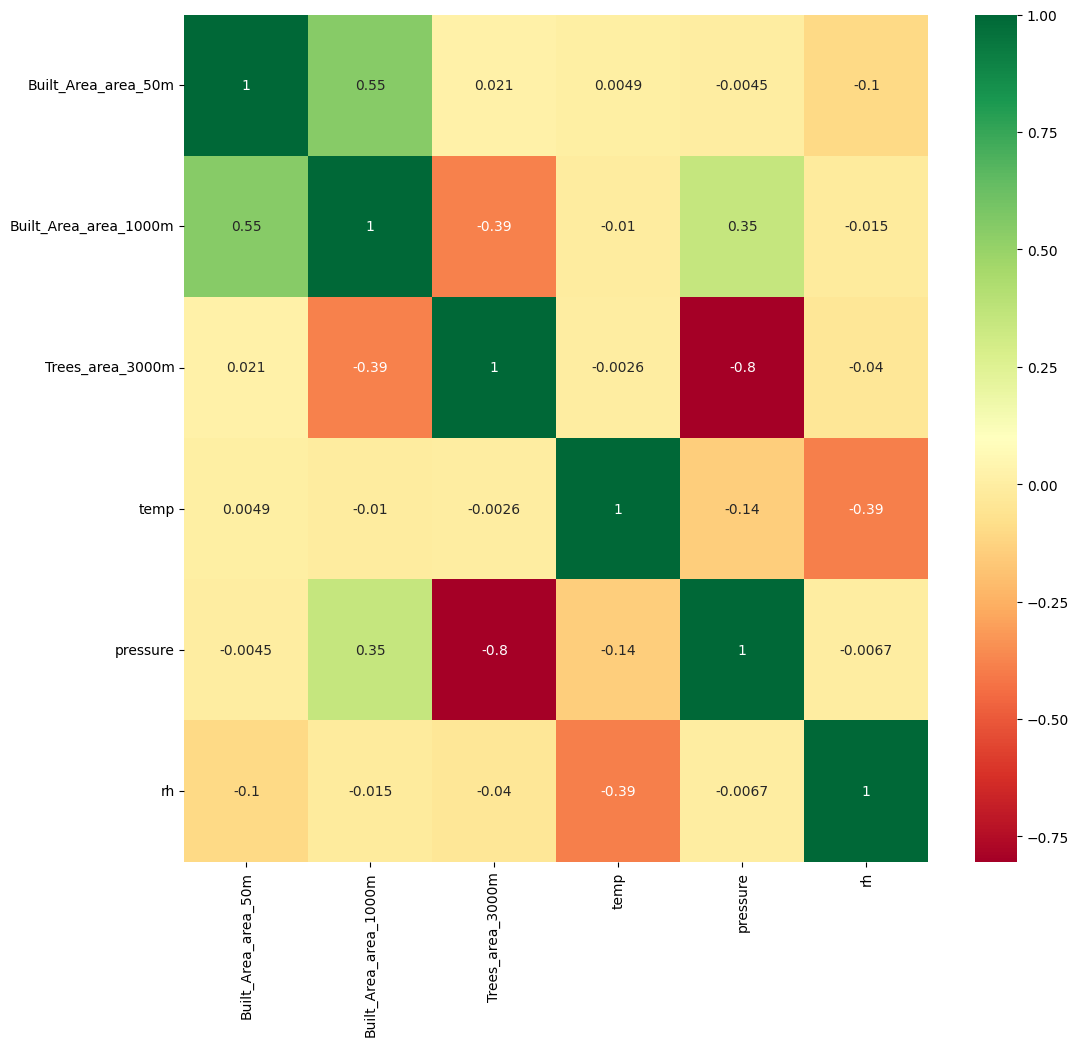

In [44]:
plot_corr(larkin_X_train)

## Lee et al.

**Feature Selection**
* To be offered to model, feature needed at least 2 non-zero observations
* Within each buffered variable group:
    - Buffer radii ranked by Pearson's correlation coefficient with pollutant
    - Top ranked buffer radius selected
    - Any variable within group highly correlated (r > 0.6) with selected variable dropped
    - Second and third ranked of remaining buffer radii also selected
* All selected variables offered to an exhaustive automated selection process (`regsubset` function frop `leaps` package in R)
    - Maximum adjusted $R^2$ used for selection
* Maximum number of predictors selected was one for every 10 observations
* Predictors removed if:
    - Sign not consistent with a-priori hypothesis
    - Not statistically significant ($p >= 0.10$)
* Automated selection process repeated until no more variables dropped
* If model included two buffer radii within 1500 m with coefficients with opposite signs, variable with the lower p-value was dropped, process rerun
* VIF calculated for each predictor
    - Drop predictors with greates VIF above the threshold (VIF=3)
    - Model refit and VIF recalculated until all remaining predictors had VIF within threshold

**Model Evaluation**
* Evaluation Metrics
    - $R^2$
    - Adj.$R^2$
    - LOOCV $R^2$
    - RMSE
    - LOOCV RMSE
    - Moran’s I
* Diagnostic plots

In [45]:
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Ranking and selecting buffer radii by pearson's correlation
ranked_buffers = {}
for group, buffers in buffer_groups.items():
    correlations = {buf: abs(pearsonr(X_train[buf], y_train)[0]) for buf in buffers if buf in X_train.columns}
    ranked_buffers[group] = sorted(correlations, key=correlations.get, reverse=True)

pearson_buffers = []
for group, buffers in ranked_buffers.items():
    if buffers:
        pearson_buffers.append(buffers[0])
        appended = 1
        remaining_buffers = buffers[1:]
        for buf in remaining_buffers:
            if appended >= 3:
                break
            if abs(pearsonr(X_train[buffers[0]], X_train[buf])[0]) <= 0.6:
                pearson_buffers.append(buf)
                appended += 1

X_train_pearson = X_train[pearson_buffers]

# Calculating R² for each feature and ranking them
r2_scores = {}
for feature in X_train_pearson.columns:
    r2_scores[feature] = pearsonr(X_train_pearson[feature], y_train)[0] ** 2
ranked_features = sorted(r2_scores, key=r2_scores.get, reverse=True)

# Checking a-priori hypothesis and p-value
lee_features = []
coefficients = {}
max_features = len(X) // 10
pvalue_threshold = 0.10

for feature in ranked_features:
    group = next((g for g, cols in buffer_groups.items() if feature in cols), None)
    if not group:
        continue
    hypothesis_direction = a_priori[group]
    
    model = OLS(y_train, add_constant(X_train_pearson[feature])).fit()
    coef = model.params.iloc[1]
    pvalue = model.pvalues.iloc[1]
    
    coef_direction = np.sign(coef)
    
    if any(char.isdigit() for char in feature):
        buffer_distance = int(''.join(filter(str.isdigit, feature)))
        for sel_feature in lee_features:
            if any(char.isdigit() for char in sel_feature):
                sel_buffer_distance = int(''.join(filter(str.isdigit, sel_feature)))
                if abs(buffer_distance - sel_buffer_distance) <= 1500 and coef_direction != coefficients.get(sel_feature, None):
                    sel_pvalue = OLS(y_train, add_constant(X_train_pearson[sel_feature])).fit().pvalues.iloc[1]
                    if pvalue < sel_pvalue:
                        lee_features.remove(sel_feature)
                        del coefficients[sel_feature]
                        break
                    else:
                        break
    
    if (coef_direction == hypothesis_direction or coef == 0) and pvalue < pvalue_threshold:
        lee_features.append(feature)
        coefficients[feature] = coef_direction
    
    if len(lee_features) >= max_features:
        break

# Dropping high VIF features
lee_features, vif = drop_high_vif(X_train_pearson[lee_features], threshold=3)

lee_features = lee_features.columns.to_list()

In [47]:
lee_X_train = X_train[lee_features]
lee_X_test = X_val[lee_features]

R²: 0.25
Adjusted R²: 0.24
Mean Squared Error (MSE): 331.78
Root Mean Squared Error (RMSE): 18.21
Mean Absolute Error (MAE): 13.87


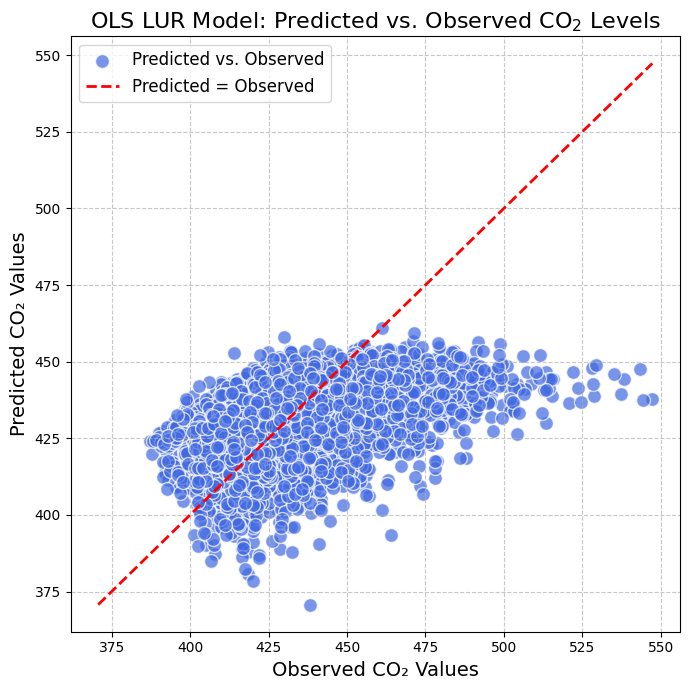

In [48]:
lee_model = OLS_Model()
lee_model.fit(lee_X_train, y_train);
lee_lur_results = lee_model.evaluate(lee_X_test, y_val)

In [50]:
cv_lee_lur_results = lee_model.cross_validate(lee_X_train, y_train)

Cross-Validation Mean Metrics:
R²: 0.24
Adjusted R²: 0.24
Mean Squared Error (MSE): 336.52
Root Mean Squared Error (RMSE): 18.34
Mean Absolute Error (MAE): 14.00


In [51]:
lee_model.feature_stats(lee_X_train, y_train)

,Feature,Coefficient,Standard Error,p-Value,VIF,Partial R²
0,temp,-6.432585,0.111945,0.000000e+00,1.051047,0.105216
1,pressure,7.834150,0.143182,0.000000e+00,1.736172,0.096342
2,Built_Area_area_1000m,-2.698210,0.183777,1.273666e-48,2.856086,0.007618
3,Built_Area_area_50m,3.172134,0.159718,3.528870e-87,2.136789,0.013853
4,total_road_length_2000m,-1.439375,0.142420,5.677471e-24,1.715607,0.003624
5,Crops_area_500m,-2.500200,0.134265,6.277435e-77,1.480768,0.012198
6,Built_Area_area_5000m,2.407361,0.176546,3.340488e-42,2.622803,0.006578
7,avg_pop_dens_1000m,0.922748,0.158055,5.336761e-09,2.114196,0.001212
8,Industrial_area_4000m,-0.873219,0.132773,4.891164e-11,1.470063,0.001538
9,total_road_length_200m,-0.128527,0.156779,4.123382e-01,2.086636,0.000024


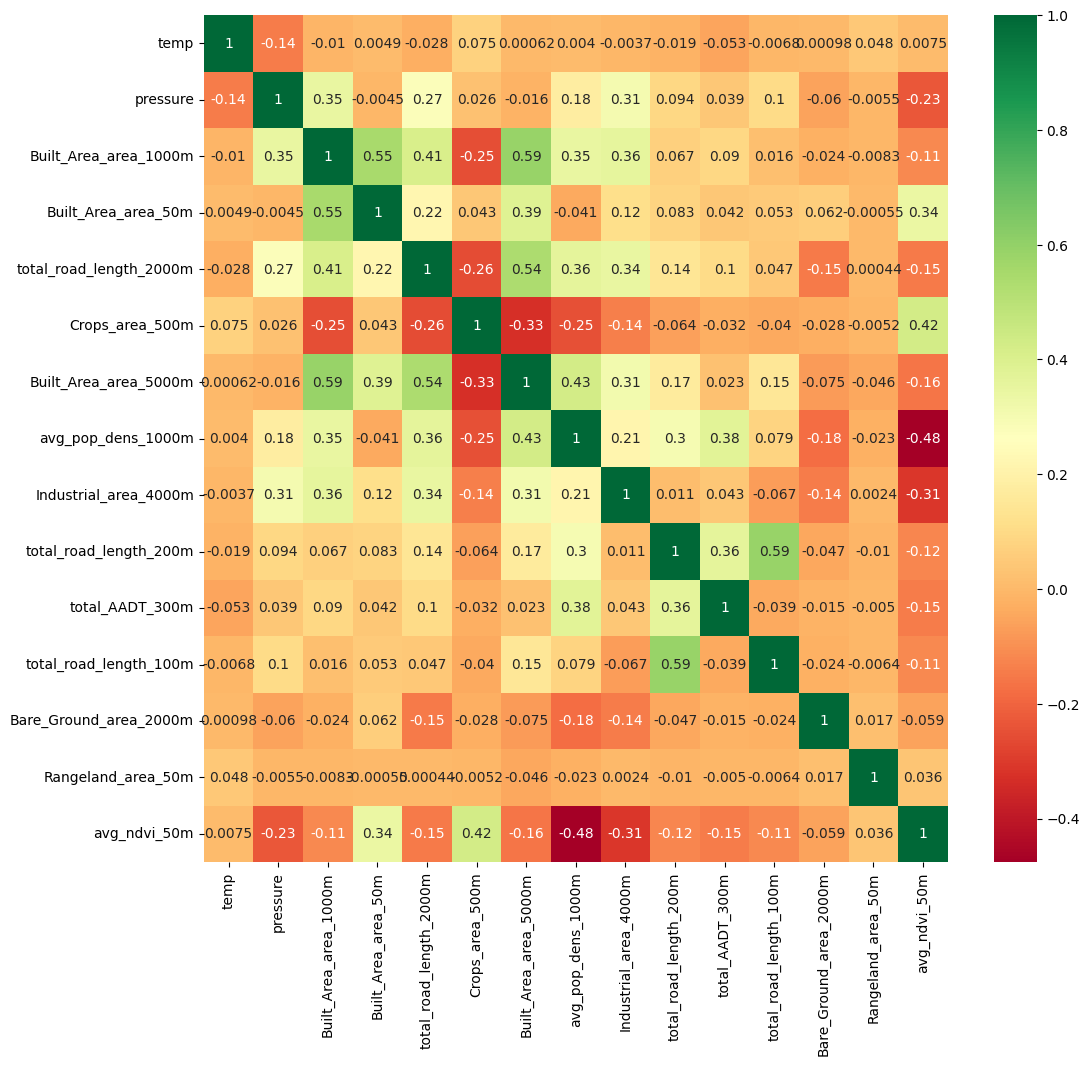

In [52]:
plot_corr(lee_X_train)

## Li et al.

**Feature Selection:**
* Supervised forward linear regression method
* First included variable with highest ajusted $R^2$
* Remaining variables included if:
    - At least 1% gain in adjusted $R^2$
    - Coefficient sign/direction consistent with a-priori hypothesis
    - Added if p-value < 0.05
        - Removed if p-value > 0.1
    - Direction of already selected variables doesn't change
    - VIF < 3
* Multiple buffer sizes of same group selected if all criteria satisfied

**Model Evaluation**

* Evaluation Metrics
    - $R^2$
    - RMSE
    - LOOCV $R^2$
    - LOOCV RMSE
* Diagnostic plots
    * Cook's distance
      - Observations with Cook's distance > 1 excluded, model re-established
    * Moran's I

In [53]:
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

features = X_train.columns.to_list()
best_adj_r2 = -np.inf
best_feature = None
r2_list = []
r2_threshold=0.001
pval_min=0.05
pval_max=0.10
    
for feature in features:
    model = sm.OLS(y_train, sm.add_constant(X_train[feature])).fit()
    r2 = model.rsquared
    n = len(y_train)
    p = 1 
    adj_r2 = calculate_adj_r2(n, p, r2)
    r2_list.append(adj_r2)
    if adj_r2 > best_adj_r2:
        best_adj_r2 = adj_r2
        best_feature = feature
    
feature_r2_tuples = list(zip(features, r2_list))
sorted_feature_r2_tuples = sorted(feature_r2_tuples, key=lambda x: x[1], reverse=True)
    
remaining_features = [feature for feature in features if feature != best_feature]
    
li_features = [best_feature]
current_adj_r2 = best_adj_r2

for feature in remaining_features:
    X_temp = X_train[li_features + [feature]]
    model = sm.OLS(y_train, sm.add_constant(X_temp)).fit()
        
    r2 = model.rsquared
    n = len(y_train)
    p = X_temp.shape[1]
    adj_r2 = calculate_adj_r2(n, p, r2)
    p_value = model.pvalues[feature]

    # Check if the coefficient direction matches the a priori hypothesis
    coef = model.params[feature]
    hypothesis_direction = a_priori.get(feature, None)
    coef_direction = np.sign(coef)
        
    if (hypothesis_direction is None or coef_direction == hypothesis_direction) and adj_r2 - current_adj_r2 >= r2_threshold and p_value < pval_min:
        li_features.append(feature)
        current_adj_r2 = adj_r2
        #print(f"Selected feature: {feature}, new adjusted R²: {current_adj_r2:.2f}")
            
        # Confirm the direction of all selected features
        for sel_feature in li_features:
            sel_coef = model.params[sel_feature]
            sel_hypothesis_direction = a_priori.get(sel_feature, None)
            sel_coef_direction = np.sign(sel_coef)
                
            if sel_hypothesis_direction is not None and sel_coef_direction != sel_hypothesis_direction:
                li_features.remove(sel_feature)
                #print(f"Removed feature: {sel_feature} due to coefficient direction mismatch")
            
        # Removing features with high p-values
        if model.pvalues.max() > pval_max:
            feature_to_remove = model.pvalues.idxmax()
            li_features.remove(feature_to_remove)
            #print(f"Removed feature: {feature_to_remove} due to high p-value")

li_features, vif = drop_high_vif(X_train[li_features], threshold=3)

li_features = li_features.columns.to_list()

In [54]:
li_X_train = X_train[li_features]
li_X_test = X_val[li_features]

R²: 0.24
Adjusted R²: 0.24
Mean Squared Error (MSE): 335.28
Root Mean Squared Error (RMSE): 18.31
Mean Absolute Error (MAE): 14.04


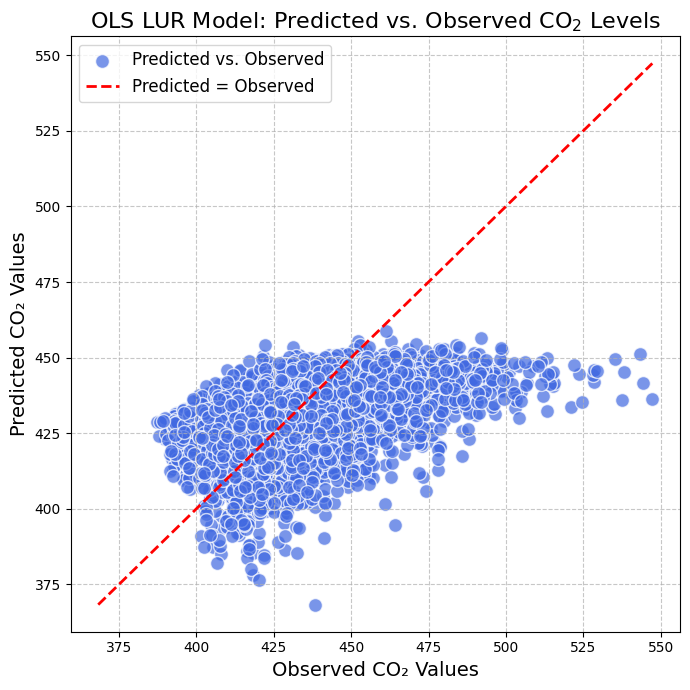

In [55]:
li_model = OLS_Model()
li_model.fit(li_X_train, y_train);
li_lur_results = li_model.evaluate(li_X_test, y_val)

In [56]:
cv_li_lur_results = li_model.cross_validate(li_X_train, y_train)

Cross-Validation Mean Metrics:
R²: 0.24
Adjusted R²: 0.24
Mean Squared Error (MSE): 337.10
Root Mean Squared Error (RMSE): 18.36
Mean Absolute Error (MAE): 14.09


In [57]:
li_model.feature_stats(li_X_train, y_train)

,Feature,Coefficient,Standard Error,p-Value,VIF,Partial R²
0,temp,-6.563751,0.111070,0.000000e+00,1.032672,0.110589
1,Built_Area_area_50m,1.018612,0.155005,5.069454e-11,2.008715,0.001535
2,Crops_area_500m,-1.949664,0.112468,5.690948e-67,1.036994,0.010586
3,Bare_Ground_area_1000m,0.936158,0.113659,1.848187e-16,1.098185,0.002410
4,Bare_Ground_area_2000m,0.035262,0.120662,7.701059e-01,1.289972,0.000003
5,Water_area_2000m,-2.719281,0.160899,9.211572e-64,2.173681,0.010067
6,Bare_Ground_area_4000m,-1.554268,0.124589,1.267251e-35,1.317351,0.005510
7,pressure,6.715668,0.117860,0.000000e+00,1.174116,0.103618


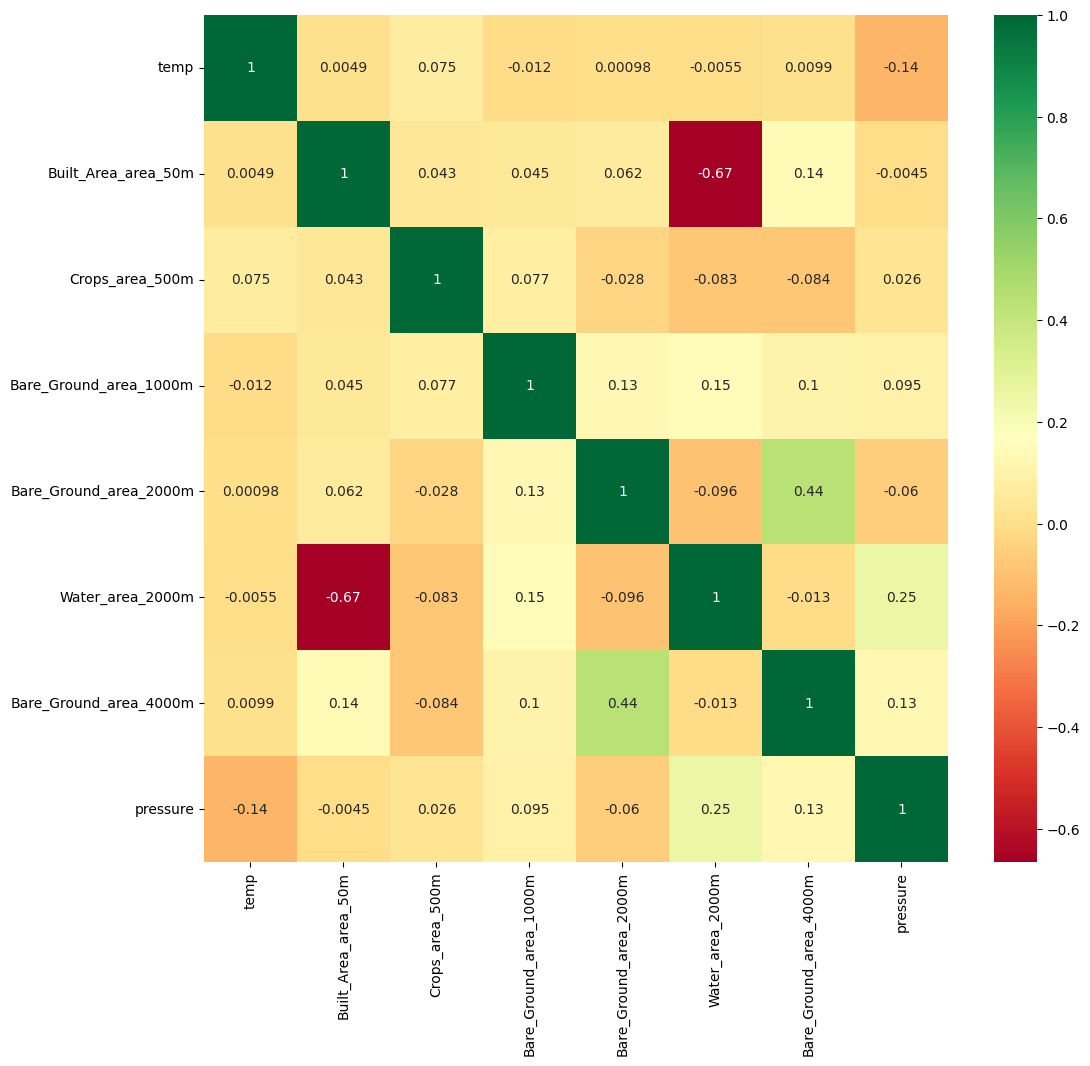

In [58]:
plot_corr(li_X_train)

## Wong et al.

**Feature Selection:**
* Stepwise variable selection procedure
* Selected only features whose Spearman's correlation coefficient matched a-priori hypothesis for initial model
* Features entered model if p-value < 0.1
    - Features removed if p-value > 0.3
* Selected only features with VIF < 3
* Selected only featues that retained correct a-priori direction
-> Used features selected by final LUR model for subsequent DL models

**Model Evaluation:**
* Evaluation Metrics:
    - $R^{2}$
    - Adj. $R^{2}$
    - MSE
    - RMSE
    - MAE
* Three validation approaches:
    - 80/20 train/test split
    - 10-fold CV, 90/10 split
    - Used 2017 and 2018 data as external data to confirm model reliability and robustness

In [59]:
# Splitting data
#X_train, _ , y_train, _ = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
#X_train, X_val, y_train, y_val, node_id_train, node_id_val = train_test_split(X_train, y_train, node_id_train, test_size=0.2, random_state=42)

In [60]:
#X_train, X_val, y_train, y_val, node_id_train, node_id_val = train_test_split(X_train, y_train, node_id_train, test_size=0.2, random_state=42)

features = X_train.columns.to_list()
    
a_priori_features  = []
for feature in features:
    if np.std(X_train[feature]) == 0:
        coef = np.nan
    else:
        coef, _ = spearmanr(X_train[feature], y_train)

    hypothesis_direction = a_priori.get(feature, None)
    coef_direction = np.sign(coef)

    if (hypothesis_direction is None or coef_direction == hypothesis_direction):
        a_priori_features.append(feature)
    
wong_features = []
for feature in a_priori_features:
    X_temp = X_train[wong_features + [feature]]
    model = sm.OLS(y_train, sm.add_constant(X_temp)).fit()
    p_value = model.pvalues[feature]
    if p_value < 0.1:
        wong_features.append(feature)
        model = sm.OLS(y_train, sm.add_constant(X_train[wong_features])).fit()
    while model.pvalues.max() > 0.3 and len(wong_features) > 1:
        worst_feature = model.pvalues.idxmax()
        if worst_feature in wong_features:
            wong_features.remove(worst_feature)
            model = sm.OLS(y_train, sm.add_constant(X_train[wong_features])).fit()
        else:
            break

model = sm.OLS(y_train, sm.add_constant(X_train[wong_features])).fit()
for feature in wong_features.copy():
    coef = model.params[feature]
    hypothesis_direction = a_priori.get(feature, None)
    coef_direction = np.sign(coef)

    if hypothesis_direction is not None and coef_direction != hypothesis_direction:
        wong_features.remove(feature)
    
wong_features, _ = drop_high_vif(X_train[wong_features])

wong_features = wong_features.columns.to_list()

In [62]:
wong_X_train = X_train[wong_features]
wong_X_val = X_val[wong_features]

R²: 0.27
Adjusted R²: 0.26
Mean Squared Error (MSE): 322.63
Root Mean Squared Error (RMSE): 17.96
Mean Absolute Error (MAE): 13.70


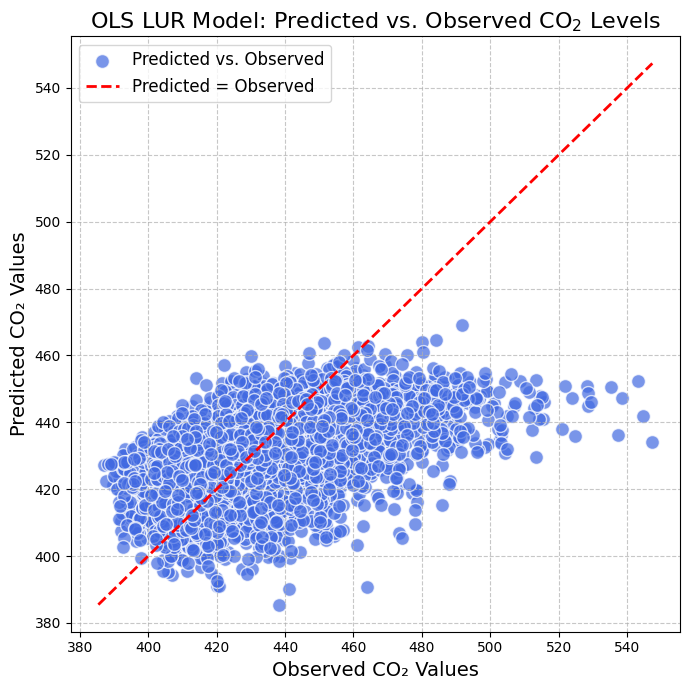

In [63]:
wong_model = OLS_Model()
wong_model.fit(wong_X_train, y_train)
wong_lur_results = wong_model.evaluate(wong_X_val, y_val)

In [64]:
cv_wong_lur_results = wong_model.cross_validate(wong_X_train, y_train)

Cross-Validation Mean Metrics:
R²: 0.27
Adjusted R²: 0.27
Mean Squared Error (MSE): 324.78
Root Mean Squared Error (RMSE): 18.02
Mean Absolute Error (MAE): 13.74


In [65]:
wong_model.feature_stats(wong_X_train, y_train)

,Feature,Coefficient,Standard Error,p-Value,VIF,Partial R²
0,Trees_area_200m,4.574476,0.146777,1.144880e-209,1.918856,0.033435
1,Rangeland_area_300m,-0.030240,0.119383,8.000371e-01,1.248036,0.000002
2,Water_area_300m,-3.534384,0.119948,5.737905e-188,1.252766,0.029993
3,Crops_area_500m,-2.060391,0.117703,3.021918e-68,1.179113,0.010795
4,Bare_Ground_area_1000m,0.192506,0.113630,9.024879e-02,1.139528,0.000102
5,Bare_Ground_area_2000m,0.282687,0.130616,3.045327e-02,1.569240,0.000167
6,Bare_Ground_area_4000m,-1.519042,0.146860,4.970171e-25,1.900276,0.003796
7,Rangeland_area_5000m,0.212110,0.162424,1.915967e-01,2.316356,0.000061
8,Industrial_area_2000m,-1.192472,0.142032,4.842950e-17,1.728860,0.002504
9,total_AADT_300m,0.522783,0.119406,1.200987e-05,1.255888,0.000682


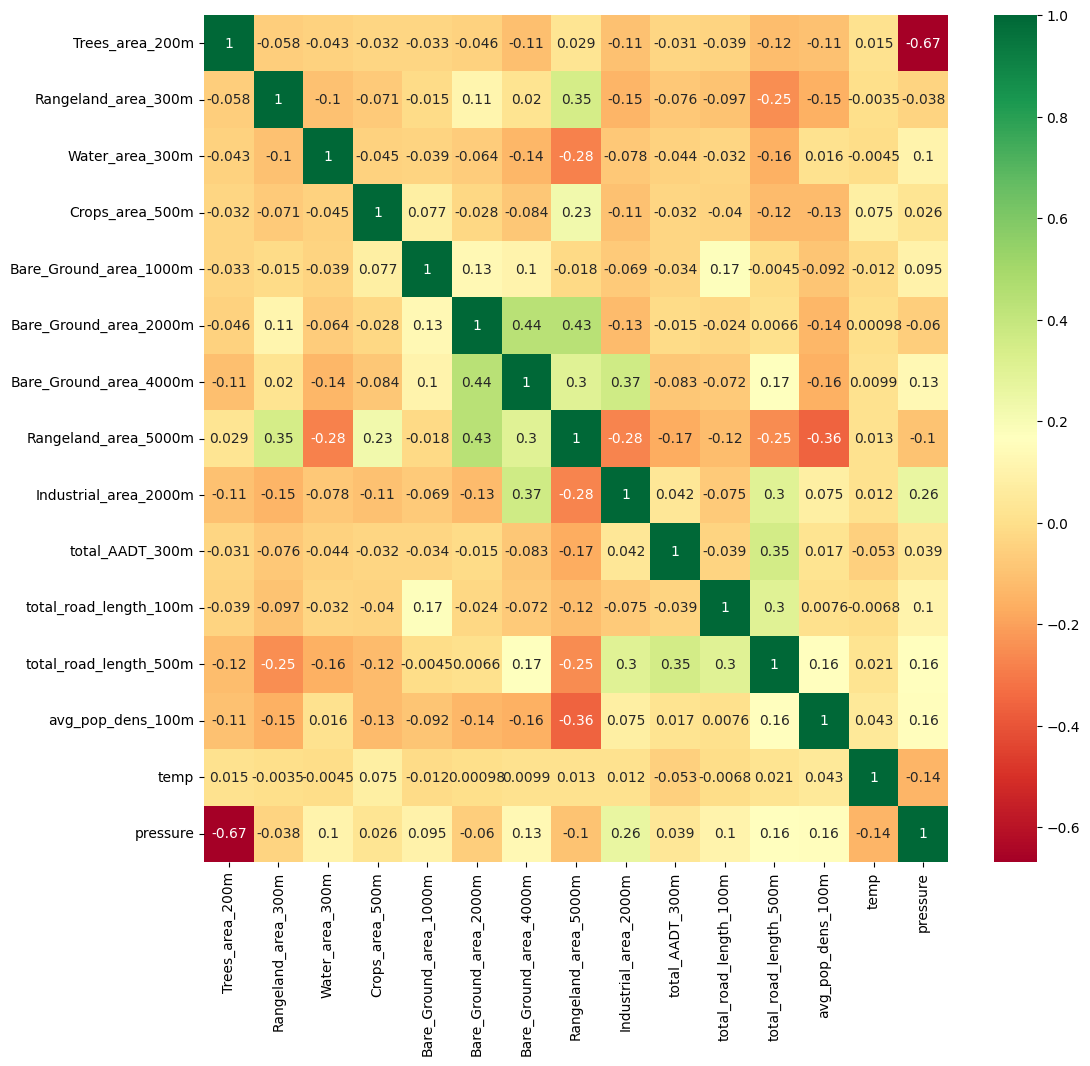

In [66]:
plot_corr(wong_X_train)

## DNN

In [67]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor

def build_dnn_model(units_layer_1=64, dropout_rate=0.01, units_layer_2=32, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(units_layer_1, activation='relu'))
    model.add(Dropout(dropout_rate))  # Dropout for first hidden layer
    model.add(Dense(units_layer_2, activation='relu'))
    model.add(Dropout(dropout_rate))  # Dropout for second hidden layer
    model.add(Dense(1, activation='linear'))  # Output layer with linear activation

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

In [68]:
#from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

# Wrap the model with KerasRegressor
input_dim = wong_X_train.shape[1]
model = KerasRegressor(model=build_dnn_model, verbose=0)

# Define the random search grid of hyperparameters
param_distributions = {
    'model__units_layer_1': [32, 64, 96],
    'model__dropout_rate': [0.0, 0.01, 0.1],
    'model__units_layer_2': [16, 32, 48],
    'model__learning_rate': [0.01, 0.001],
    'epochs': [50, 100],
    'batch_size': [16, 32]
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, n_iter=10, cv=3, scoring='r2', verbose=2, n_jobs=-1)

# Perform the random search
random_search_result = random_search.fit(wong_X_train, y_train)

# Output the best hyperparameters and the corresponding score
print(f"Best Hyperparameters: {random_search_result.best_params_}")
print(f"Best Score: {random_search_result.best_score_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END batch_size=32, epochs=50, model__dropout_rate=0.01, model__learning_rate=0.01, model__units_layer_1=32, model__units_layer_2=32; total time=  29.8s
[CV] END batch_size=32, epochs=50, model__dropout_rate=0.01, model__learning_rate=0.01, model__units_layer_1=32, model__units_layer_2=32; total time=  30.0s
[CV] END batch_size=32, epochs=50, model__dropout_rate=0.01, model__learning_rate=0.01, model__units_layer_1=32, model__units_layer_2=32; total time=  30.2s
[CV] END batch_size=16, epochs=50, model__dropout_rate=0.01, model__learning_rate=0.001, model__units_layer_1=96, model__units_layer_2=32; total time=  54.0s
[CV] END batch_size=16, epochs=50, model__dropout_rate=0.01, model__learning_rate=0.001, model__units_layer_1=96, model__units_layer_2=32; total time=  54.0s
[CV] END batch_size=16, epochs=50, model__dropout_rate=0.01, model__learning_rate=0.001, model__units_layer_1=96, model__units_layer_2=32; total time=  

In [71]:
best_model = random_search_result.best_estimator_

y_pred = best_model.predict(wong_X_val)

mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 249.92166458699313
R-squared: 0.431648305764716


In [76]:
# Build the DNN model
def build_dnn_model(input_dim):
    model = Sequential()
    model.add(Dense(32, input_dim=input_dim, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='linear'))  # Output layer with linear activation

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model


In [77]:
# Initialize the model
input_dim = wong_X_train.shape[1]
dnn_model = build_dnn_model(input_dim)

# Train the model
dnn_model.fit(wong_X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/100


/Users/annasmith/anaconda3/envs/irp/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


703/703 ━━━━━━━━━━━━━━━━━━━━ 1s 387us/step - loss: 156865.3281 - val_loss: 4857.2710
Epoch 2/100
703/703 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 3079.9355 - val_loss: 1516.1912
Epoch 3/100
703/703 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step - loss: 1321.1693 - val_loss: 942.6028
Epoch 4/100
703/703 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - loss: 857.6587 - val_loss: 664.6180
Epoch 5/100
703/703 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - loss: 601.5874 - val_loss: 529.0668
Epoch 6/100
703/703 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step - loss: 492.1849 - val_loss: 458.9123
Epoch 7/100
703/703 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step - loss: 435.2657 - val_loss: 409.1557
Epoch 8/100
703/703 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step - loss: 392.9859 - val_loss: 383.6860
Epoch 9/100
703/703 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - loss: 368.6833 - val_loss: 361.7975
Epoch 10/100
703/703 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step - loss: 349.5457 - val_loss: 338.9188
Epoch 11/100
703/703 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step - loss: 333.7315 -

In [78]:
mse = dnn_model.evaluate(wong_X_val, y_val, verbose=0)
print(f"Mean Squared Error on test data: {mse}")

# Make predictions
y_pred = dnn_model.predict(wong_X_val)

# Calculate R²
r2 = r2_score(y_val, y_pred)
print(f"R² on test data: {r2}")

Mean Squared Error on test data: 256.1148986816406
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
R² on test data: 0.41756416363819826


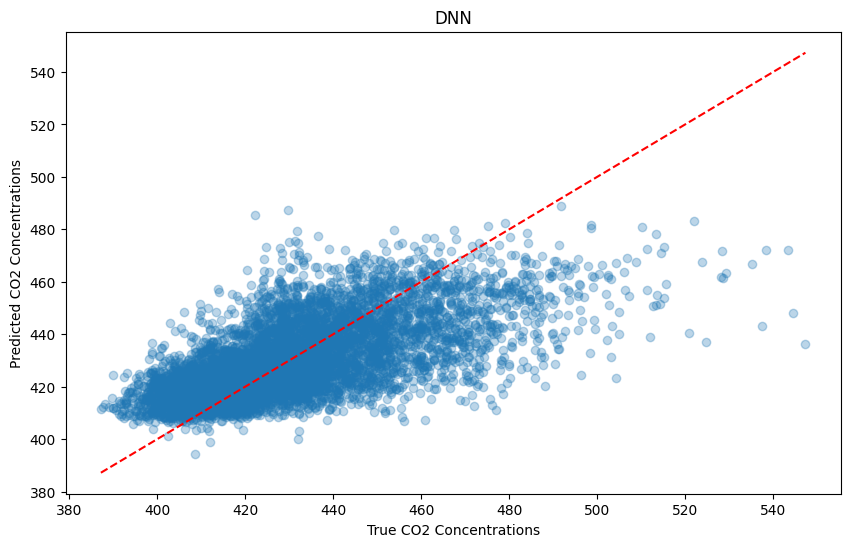

In [80]:
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.3)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')  # Red dashed line for y=x
plt.xlabel('True CO2 Concentrations')
plt.ylabel('Predicted CO2 Concentrations')
plt.title('DNN')
plt.show()

## Random Forest

In [82]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Initialize the RF model with initial parameters
rf = RandomForestRegressor(n_estimators=200, max_depth=17, random_state=42)

# Train the RF model
rf.fit(wong_X_train, y_train)

# Make predictions
y_pred = rf.predict(wong_X_val)

# Calculate MSE and R²
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f"Initial Mean Squared Error on test data: {mse}")
print(f"Initial R² on test data: {r2}")

Initial Mean Squared Error on test data: 252.85891482839608
Initial R² on test data: 0.42496864814538515


In [83]:
# Define parameter grid for Grid Search
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 15, 20, 25, 30, None]
}

# Initialize Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit the Grid Search to the data
grid_search.fit(wong_X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END .....................max_depth=10, n_estimators=100; total time=   4.8s
[CV] END .....................max_depth=10, n_estimators=100; total time=   4.8s
[CV] END .....................max_depth=10, n_estimators=100; total time=   4.8s
[CV] END .....................max_depth=10, n_estimators=100; total time=   4.8s
[CV] END .....................max_depth=10, n_estimators=100; total time=   4.9s
[CV] END .....................max_depth=10, n_estimators=200; total time=  10.0s
[CV] END .....................max_depth=10, n_estimators=200; total time=  10.1s
[CV] END .....................max_depth=10, n_estimators=200; total time=  10.1s
[CV] END .....................max_depth=10, n_estimators=200; total time=  10.1s
[CV] END .....................max_depth=10, n_estimators=200; total time=  10.1s
[CV] END .....................max_depth=10, n_estimators=300; total time=  15.8s
[CV] END .....................max_depth=10, n_e

/Users/annasmith/anaconda3/envs/irp/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END .....................max_depth=20, n_estimators=300; total time=  33.0s
[CV] END .....................max_depth=20, n_estimators=300; total time=  24.5s
[CV] END .....................max_depth=20, n_estimators=300; total time=  23.5s
[CV] END .....................max_depth=20, n_estimators=300; total time=  23.7s
[CV] END .....................max_depth=20, n_estimators=400; total time=  30.3s
[CV] END .....................max_depth=20, n_estimators=400; total time=  30.4s
[CV] END .....................max_depth=20, n_estimators=400; total time=  30.4s
[CV] END .....................max_depth=25, n_estimators=100; total time=   9.7s
[CV] END .....................max_depth=25, n_estimators=100; total time=   9.7s
[CV] END .....................max_depth=20, n_estimators=400; total time=  36.6s
[CV] END .....................max_depth=20, n_estimators=400; total time=  39.2s
[CV] END .....................max_depth=25, n_estimators=100; total time=   9.3s
[CV] END ...................

In [84]:
# Initialize and train the RF model with the best parameters
best_rf = RandomForestRegressor(n_estimators=best_params['n_estimators'], 
                                max_depth=best_params['max_depth'], 
                                random_state=42)

best_rf.fit(wong_X_train, y_train)

# Make predictions with the optimized model
best_y_pred = best_rf.predict(wong_X_val)

# Calculate MSE and R² with the optimized model
best_mse = mean_squared_error(y_val, best_y_pred)
best_r2 = r2_score(y_val, best_y_pred)
print(f"Optimized Mean Squared Error on test data: {best_mse}")
print(f"Optimized R² on test data: {best_r2}")

Optimized Mean Squared Error on test data: 249.66765783445538
Optimized R² on test data: 0.4322259474365199


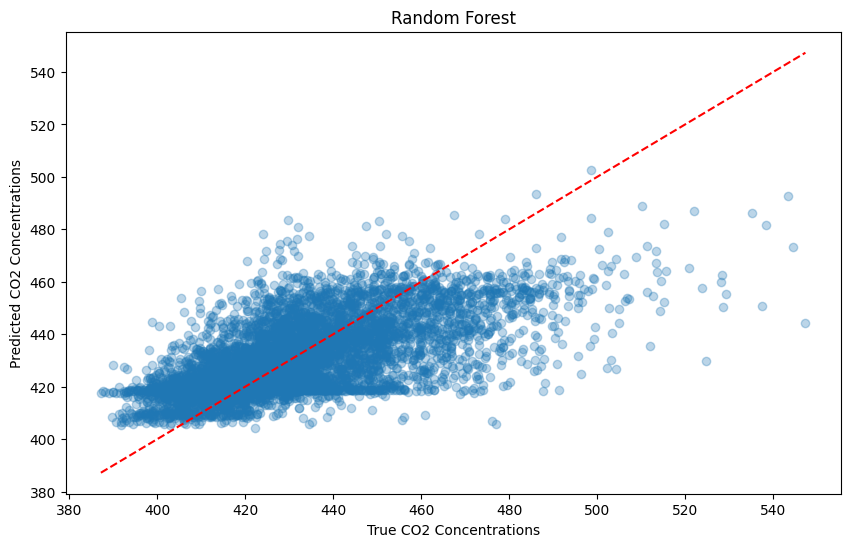

In [85]:
plt.figure(figsize=(10, 6))
plt.scatter(y_val, best_y_pred, alpha=0.3)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')  # Red dashed line for y=x
plt.xlabel('True CO2 Concentrations')
plt.ylabel('Predicted CO2 Concentrations')
plt.title('Random Forest')
plt.show()

## XGBoost

In [86]:
import xgboost as xgb

# Define the XGBoost model
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter grid for optimization
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# Perform Grid Search with 10-fold cross-validation
grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(wong_X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

Fitting 10 folds for each of 27 candidates, totalling 270 fits


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estima

/Users/annasmith/anaconda3/envs/irp/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=15, n_estimators=200, subsample=0.8; total time=   6.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=15, n_estimators=200, subsample=0.8; total time=   6.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=15, n_estimators=200, subsample=0.8; total time=   6.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=15, n_estimators=200, subsample=0.8; total time=   6.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_es

In [113]:
# Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}

In [87]:
# Train the model with the best parameters
best_xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', **best_params)
best_xgboost_model.fit(wong_X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [90]:
y_pred = best_xgboost_model.predict(wong_X_val)

# Calculate evaluation metrics
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
n = X_val.shape[0]
p = X_val.shape[1]
adjusted_r2 = 1 - (1-r2) * (n-1) / (n-p-1)

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R²: {r2}")
print(f"Adjusted R²: {adjusted_r2}")

Mean Squared Error (MSE): 239.15220289168212
Root Mean Squared Error (RMSE): 15.464546643587134
Mean Absolute Error (MAE): 11.46112457320486
R²: 0.456139347030174
Adjusted R²: 0.4478061251141865


In [91]:
from sklearn.model_selection import cross_val_score

# 10-fold cross-validation for MSE
cv_scores = cross_val_score(best_xgboost_model, wong_X_train, y_train, cv=10, scoring='neg_mean_squared_error')
cv_mse = -cv_scores.mean()
cv_rmse = np.sqrt(cv_mse)
print(f"10-fold CV Mean Squared Error (MSE): {cv_mse}")
print(f"10-fold CV Root Mean Squared Error (RMSE): {cv_rmse}")

# 10-fold cross-validation for R²
cv_r2_scores = cross_val_score(best_xgboost_model, wong_X_train, y_train, cv=10, scoring='r2')
cv_r2 = cv_r2_scores.mean()
print(f"10-fold CV R²: {cv_r2}")

# 10-fold cross-validation for MAE
cv_mae_scores = cross_val_score(best_xgboost_model, wong_X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
cv_mae = -cv_mae_scores.mean()
print(f"10-fold CV Mean Absolute Error (MAE): {cv_mae}")

# Calculate adjusted R²
n = len(y_train)
p = wong_X_train.shape[1]
cv_adjusted_r2 = calculate_adj_r2(n, p, cv_r2)
print(f"10-fold CV Adjusted R²: {cv_adjusted_r2}")

10-fold CV Mean Squared Error (MSE): 239.63206160369265
10-fold CV Root Mean Squared Error (RMSE): 15.48005366927688
10-fold CV R²: 0.461529696292106
10-fold CV Mean Absolute Error (MAE): 11.355817552553221
10-fold CV Adjusted R²: 0.4612420518990997
